### first training a dense AE then using CNNs to classify if it is fake or real

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

# -----------------------------------------------------------------------------
# hyperparams
# -----------------------------------------------------------------------------

np.random.seed(0)
batch_size = 64
num_epochs = 50


print('Starting....')
# -----------------------------------------------------------------------------

data_folder = './ProcessedData'
file_list = os.listdir(data_folder)

one_list = np.load('./one_list.npy', allow_pickle=True)
zero_list = np.load('./zero_list.npy', allow_pickle=True)
print(f' length list 1: {len(one_list)}')
print(f'length list 0: {len(zero_list)}')
# print('Done!')

# -----------------------------------------------------------------------------
# shuffling + splitting for test and train
# -----------------------------------------------------------------------------
label_0_files = zero_list
label_1_files = (one_list)


print(type(label_0_files), type(label_1_files))
len_zero = (len(zero_list)) //2
len_one = (len(one_list)) //2

# print(f'Half {len(len_zero)}')
# print(label_0_files[:100].shape+ label_1_files[:100].shape)

np.random.shuffle(label_0_files)
np.random.shuffle(label_1_files)

half = 11300
train_files = list(label_0_files)[:half] + list(label_1_files)[:half]
test_files = list(label_0_files)[half:] + list(label_1_files)[half:]


# -----------------------------------------------------------------------------
# creating a customdataset
# -----------------------------------------------------------------------------
class CustomDataset(Dataset):
    def __init__(self, file_list, data_folder):
        self.file_list = file_list
        self.data_folder = data_folder

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
     
        file_path = os.path.join(self.data_folder, self.file_list[idx])
        data = np.load(file_path, allow_pickle=True)

        mfcc_lfcc_array = data[0]
        cqcc_lpcc_array = data[1]
        label = data[2]

        concatenated_features = np.concatenate((mfcc_lfcc_array[0], mfcc_lfcc_array[1]), axis=-1)
        concatenated_features = np.expand_dims(concatenated_features, axis=0)
        

        return concatenated_features, label


train_dataset = CustomDataset(train_files, data_folder)
test_dataset = CustomDataset(test_files, data_folder)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------------------------------------------------------
# getting the shapes for inputs and labels
# -----------------------------------------------------------------------------
print('-----------Going through dataloaders to see the shapes')
for inputs, labels in train_loader:
    print(inputs.shape)
    print(labels.shape)
    break

for inputs, labels in test_loader:
    print(inputs.shape)
    print(labels.shape)
    break


labels_count = {0: 0, 1: 0}

for features, label in train_dataset:
    labels_count[label] += 1

# print("Label 0 count:", labels_count[0])
# print("Label 1 count:", labels_count[1])


Starting....
 length list 1: 22600
length list 0: 22600
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
-----------Going through dataloaders to see the shapes
torch.Size([64, 1, 13, 4])
torch.Size([64])
torch.Size([64, 1, 13, 4])
torch.Size([64])


In [34]:
# # -----------------------------------------------------------------------------
# # VAE
# # -----------------------------------------------------------------------------


input_size =  4
hidden_size = 512
hidden_size1= 64
hidden_size2 = 128
latent_size = 64
learning_rate = 0.001

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        # Decoder
        self.fc_decode = nn.Linear(latent_size, hidden_size)
        self.fc_output1 = nn.Linear(hidden_size, hidden_size1)
        self.fc_output2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc_output3 = nn.Linear(hidden_size2, input_size)

    def encode(self, x):
        # print(x.shape)
       
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # print(x.shape)
        z = self.fc_mu(x)
        
        return z
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.fc_decode(z))
        z = F.relu(self.fc_output1(z))
        z = F.relu(self.fc_output2(z))
        x = torch.sigmoid(self.fc_output3(z))
        return x

    def forward(self, x):
        z = self.encode(x)
        
        x_recon = self.decode(z)
        return x_recon, z




# # Create VAE model, loss function, and optimizer
vae_model = VAE().double() 
criterion = nn.MSELoss().double() 
optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)

print('-------------VAE training starting....')
# Training loop
for epoch in range(num_epochs):
    for data, _ in train_loader:
        # Get input data
        inputs = data.double() 
        # print(inputs.shape)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        recon, z = vae_model(inputs)
        # print(mu.shape) # 64, 128

        # Compute loss
        reconstruction_loss = criterion(recon, inputs)
        
        loss = reconstruction_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print training statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# # Save the trained model
torch.save(vae_model.state_dict(), './vae.pth')


-------------VAE training starting....
Epoch 1/50, Loss: 0.21649201353919725
Epoch 2/50, Loss: 0.32168525829601946
Epoch 3/50, Loss: 0.2344155775178995
Epoch 4/50, Loss: 0.22746558876372225
Epoch 5/50, Loss: 0.2075733086988763
Epoch 6/50, Loss: 0.26704809227800885
Epoch 7/50, Loss: 0.3033462450928127
Epoch 8/50, Loss: 0.17909451309632418
Epoch 9/50, Loss: 0.4907116071284404
Epoch 10/50, Loss: 0.28206572589675555
Epoch 11/50, Loss: 0.3895665791284368
Epoch 12/50, Loss: 0.2886044929424652
Epoch 13/50, Loss: 0.375392993588006
Epoch 14/50, Loss: 0.3309591652339228
Epoch 15/50, Loss: 0.2739635116400362
Epoch 16/50, Loss: 0.34009937860920114
Epoch 17/50, Loss: 0.24065882727364218
Epoch 18/50, Loss: 0.40065474890448083
Epoch 19/50, Loss: 0.1748946047686579
Epoch 20/50, Loss: 0.22538352865514086
Epoch 21/50, Loss: 0.19075864456625655
Epoch 22/50, Loss: 0.33494639611455185
Epoch 23/50, Loss: 0.2464496795877625
Epoch 24/50, Loss: 0.3391967889614265
Epoch 25/50, Loss: 0.2643496818505829
Epoch 26/

-----------Training
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])


/var/folders/zj/t98zryp54gq7l4jzwy8sc5xm0000gn/T/ipykernel_92226/994108701.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/zj/t98zryp54gq7l4jzwy8sc5xm0000gn/T/ipykernel_92226/994108701.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
torch.Size([64, 2]) torch.Size([64])
 Shape of latent

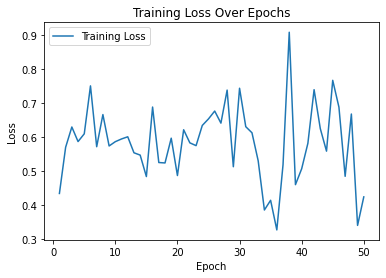

In [35]:
# -----------------------------------------------------------------------------
# CNN
# -----------------------------------------------------------------------------
in_size = 1

class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        # self.fc_decode = nn.Linear(128, 3328)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
    
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(480 , 12)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(12, 2)  

    def forward(self, x):
        # print('------------')
        # x = F.relu(self.fc_decode(x))
        # print(f'shape of x {x.shape}')
        # x = x.view(x.size(0), 64, 13, 4)
        print(f'shape of x {x.shape}')  
  
        x = self.conv1(x)
        # print(x.shape)
        x = self.relu1(x)
        # print(x.shape)
        x = self.pool1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.relu2(x)
      
        # print(x.shape)
        x = self.pool2(x)
        # print(x.shape)
        x = self.flatten(x)
        print(f' after flattening {x.shape}')
        x = self.fc1(x)
        # print(x.shape)
        x = self.relu3(x)
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x

model = AudioClassifier()
vae_model = VAE()
PATH = './vae.pth'
state_dict = torch.load(PATH)
vae_model.load_state_dict(state_dict)
vae_model.eval()


model = AudioClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)

# -----------------------------------------------------------------------------
# training loop
# -----------------------------------------------------------------------------
print('-----------Training')
loss_values = []
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
   
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        z = vae_model.encode(inputs)
        # z = torch.unsqueeze(z, 0)


       
        print(f' Shape of latent is {z.shape}')
        outputs = model(z)
        print(outputs.shape, labels.shape)

  
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_values.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

plt.plot(range(1, num_epochs+1), loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
# plt.savefig('../los_per_epoch_vae.png')
plt.show()


In [36]:

model.eval()
correct = 0
predicted_labels = []
total = 0
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
    
        inputs = torch.tensor(inputs, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)
        z = vae_model.encode(inputs)
      
        # z = torch.unsqueeze(z, 0)

       
        print(f' Shape of latent is {z.shape}')
        outputs = model(z)
        # \outputs = torch.unsqueeze(outputs , 0)

        _, predicted = torch.max(outputs, 1)
        print(f'total size {outputs.shape}')

        total += labels.size(0)
        # print(f'total size {total}')
        print(f'predicted {predicted.shape} labels {labels.shape}')
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())


accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
total size torch.Size([64, 2])
predicted torch.Size([64]) labels torch.Size([64])


/var/folders/zj/t98zryp54gq7l4jzwy8sc5xm0000gn/T/ipykernel_92226/2661472285.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)
/var/folders/zj/t98zryp54gq7l4jzwy8sc5xm0000gn/T/ipykernel_92226/2661472285.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
total size torch.Size([64, 2])
predicted torch.Size([64]) labels torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
total size torch.Size([64, 2])
predicted torch.Size([64]) labels torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
total size torch.Size([64, 2])
predicted torch.Size([64]) labels torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
total size torch.Size([64, 2])
predicted torch.Size([64]) labels torch.Size([64])
 Shape of latent is torch.Size([64, 1, 13, 64])
shape of x torch.Size([64, 1, 13, 64])
 after flattening torch.Size([64, 480])
total size torch.Size([64, 2])
predic